<a href="https://colab.research.google.com/github/SMKProj/FGSM/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout,Flatten
from keras import Sequential
from keras.datasets import mnist
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.losses import MSE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist
import numpy as np
import cv2

In [ ]:
def build():
  model = Sequential()
  model.add(Dropout(0.4, input_shape=(784,)))
  model.add(Dense(20, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))
  model.summary()
  return model

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], 28 * 28 * 1))
x_test = x_test.reshape((x_test.shape[0], 28 * 28 * 1))
x_train,x_test = x_train.astype("float32")/255.0, x_test.astype("float32") / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# one-hot encode our labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [ ]:
# creating testset from validation set
x_val,y_val = x_test[:-10],y_test[:-10]
x_test,y_test = x_test[-10:], y_test[-10:]

In [ ]:
# initialize our optimizer and model
opt = Adam(learning_rate=1e-3)
model = build()
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"])

history = model.fit(x_train, y_train,validation_data=(x_val, y_val),batch_size=64,epochs=20,verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                15700     
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 1.2360 - accuracy: 0.6361 - val_loss: 0.5904 - val_accuracy: 0.8805
Epoch 2/20
938/938 [====================

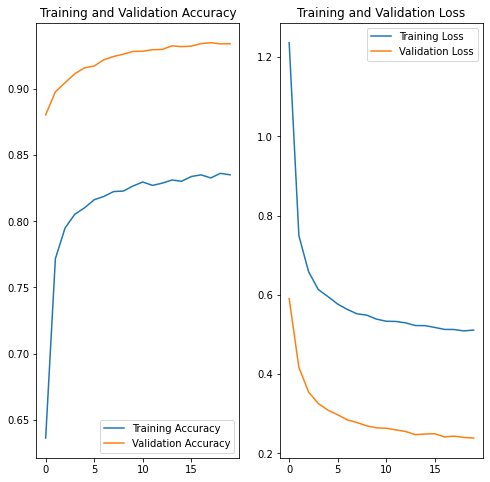

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
probs = model.predict(x=x_test)
(loss, acc) = model.evaluate(x=x_test, y=y_test, verbose=0)
print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))

print("True label : ", "Predicted label : ")
for i in range(len(y_test)):
  print("\t", y_test[i].argmax(), "\t", probs[i].argmax())

[INFO] loss: 0.1201, acc: 1.0000
True label :  Predicted label : 
	 7 	 7
	 8 	 8
	 9 	 9
	 0 	 0
	 1 	 1
	 2 	 2
	 3 	 3
	 4 	 4
	 5 	 5
	 6 	 6


In [ ]:
def create_adversarial_image(input_image, input_label,eps):
  input_image = tf.cast(input_image, tf.float32)# cast the image
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = MSE(input_label,prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  # creating adversary image
  adversary = (input_image + (signed_grad * eps)).numpy()
  return adversary

In [ ]:
from google.colab.patches import cv2_imshow

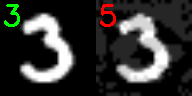

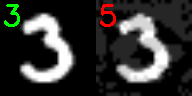

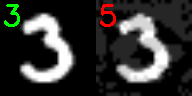

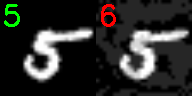

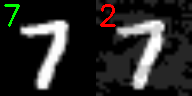

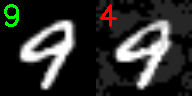

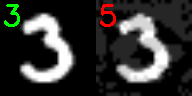

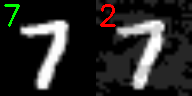

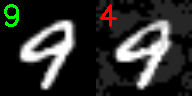

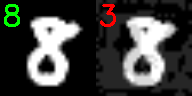

In [ ]:
# loop over a sample of our testing images
for i in np.random.choice(np.arange(0, len(x_test)), size=(10,)):
  image = x_test[i]
  label = y_test[i]
  adversary = create_adversarial_image(image.reshape(1,784), label, eps=0.15)
  pred = model.predict(adversary)

  imagePred = label.argmax()
  adversaryPred = pred[0].argmax()

  adversary = adversary.reshape((28, 28)) * 255
  adversary = np.clip(adversary, 0, 255).astype("uint8")
  image = image.reshape((28, 28)) * 255
  image = image.astype("uint8")
  image = np.dstack([image] * 3)
  adversary = np.dstack([adversary] * 3)
  image = cv2.resize(image, (96, 96))
  adversary = cv2.resize(adversary, (96, 96))

  imagePred = label.argmax()
  adversaryPred = pred[0].argmax()
  color = (0, 255, 0)
  if imagePred != adversaryPred:
    color = (0, 0, 255)
    cv2.putText(image, str(imagePred), (2, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
    cv2.putText(adversary, str(adversaryPred), (2, 25),
		cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
  output = np.hstack([image, adversary])
  cv2_imshow(output)
  cv2.waitKey(0)